In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [355]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Import data and merge replicates

In [356]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
                    index_col=0)
merged.index = merged.index.str.rstrip('-12345')
mean_df = merged.groupby('ID').mean()
# Get rid of cold work
cw_regex = re.compile("[0-9]+$") 
mean_df['cold_work'] = [int(re.search(cw_regex,x).group()) for x in mean_df.index]
mean_df.index = mean_df.index.str.rstrip('02468')
mean_df.index = mean_df.index.str.rstrip('-')

In [357]:
mean_df

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS,cold_work
ID,,,,,,,,,,,,,,,
304,162.000000,0.12000,0.0350,0.08600,-1.54700,0.04900,0.002743,0.0,0.013,2.9,0.0,0.005,1.3,0.0,0
304,105.780000,0.49600,0.1770,0.23900,-1.32200,0.06300,0.002093,50.0,0.014,2.0,59.0,0.006,1.1,-12.0,20
304,100.700000,1.35000,0.3770,0.37700,-1.21600,0.05300,0.001941,57.0,0.022,3.0,79.0,0.012,1.9,-20.0,40
304,91.320000,1.37100,0.5310,0.90900,-1.24900,0.05200,0.002567,98.0,0.010,1.1,139.0,0.015,1.7,3.0,60
304,73.775000,3.96600,1.3495,2.47650,-0.97600,0.06425,0.002420,94.0,0.024,2.7,149.0,0.021,2.4,10.0,80
316,111.240000,0.03900,0.0140,0.01700,-1.50600,0.04600,0.002433,0.0,0.021,4.6,0.0,0.010,2.4,0.0,0
316,69.960000,0.03600,0.0100,0.01600,-1.57300,0.04500,0.002785,42.0,0.032,5.0,37.0,0.004,0.7,30.0,20
316,68.220000,0.04400,0.0160,0.01700,-1.64000,0.04400,0.002494,70.0,0.007,1.0,60.0,0.005,0.8,-34.0,40
316,69.000000,0.04925,0.0165,0.03275,-1.67375,0.04500,0.002292,117.0,0.017,1.8,200.0,0.013,1.0,-57.0,60


## Select columns of interest

In [359]:
mean_df = mean_df[mc.regression_cols_real_data].dropna()

In [360]:
mean_df

,KJIC,TEP_average,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
ID,,,,,
304,162.000000,-1.54700,0.0,0.0,0.0
304,105.780000,-1.32200,50.0,59.0,-12.0
304,100.700000,-1.21600,57.0,79.0,-20.0
304,91.320000,-1.24900,98.0,139.0,3.0
304,73.775000,-0.97600,94.0,149.0,10.0
316,111.240000,-1.50600,0.0,0.0,0.0
316,69.960000,-1.57300,42.0,37.0,30.0
316,68.220000,-1.64000,70.0,60.0,-34.0
316,69.000000,-1.67375,117.0,200.0,-57.0


## Scale data

In [361]:
# Introducing the logarithmic of KJIC
mean_df.KJIC = np.log(mean_df.KJIC)
scaled_df = mc.scale_general(mean_df, MinMaxScaler())
scaled_df[0]

,KJIC,TEP_average,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
ID,,,,,
304,0.858609,0.148811,0.000000,0.000000,0.696970
304,0.562016,0.412973,0.083195,0.051937,0.575758
304,0.527769,0.537423,0.094842,0.069542,0.494949
304,0.459733,0.498679,0.163062,0.122359,0.727273
304,0.311274,0.819196,0.156406,0.131162,0.797980
316,0.597037,0.196947,0.000000,0.000000,0.696970
316,0.274327,0.118286,0.069884,0.032570,1.000000
316,0.256802,0.039624,0.116473,0.052817,0.353535
316,0.264713,0.000000,0.194676,0.176056,0.121212


<AxesSubplot:>

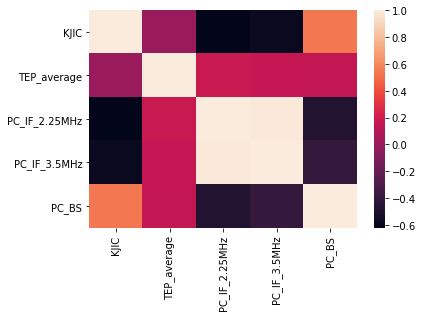

In [362]:
sns.heatmap(mean_df.corr())

In [367]:
SS_304=scaled_df[0].iloc[0:5]
SS_316=scaled_df[0].iloc[5:10]
SS_347=scaled_df[0].iloc[10:15]
SS_A286=scaled_df[0].iloc[15:20]

,KJIC,TEP_average,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
ID,,,,,
A286,0.958565,0.405929,0.000000,0.000000,0.696970
A286,0.293844,0.503375,1.000000,1.000000,0.515152
A286,0.000000,0.355445,0.881864,0.774648,0.292929
A286,0.059808,0.243910,0.833611,0.668134,0.050505


In [368]:
SS_list=["SS304","SS316","SS347","SSA286"]

## Linear Regression

In [369]:
def lr_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    # Model Liner Regression
    lr = LinearRegression()
    
    #Train/fit the model to training data
    lr.fit(X_train,y_train)
    
    pred = lr.predict(X_test)
    
    # print the intercept
    print("Intercept:", lr.intercept_)
    
    #Coefficients
    coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
    print("Coefficients:", coeff_df)
    
    
    print("r2 score for training: ", r2_score(y_train, lr.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, pred))
    
    print('MAE:', metrics.mean_absolute_error(y_test, pred))
    print('MSE:', metrics.mean_squared_error(y_test, pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
    
    plt.scatter(y_test,pred)
    plt.title("Linear Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (3, 4)
Test dataset: (2, 4)
Intercept: 0.6514040767482367
Coefficients:                Coefficient
TEP_average      -0.794625
PC_IF_2.25MHz    -0.263963
PC_IF_3.5MHz     -0.156391
PC_BS             0.466956
r2 score for training:  1.0
r2 score for testing:  -6.350783209454291
MAE: 0.09052047640220573
MSE: 0.008506736333389006
RMSE: 0.09223197023477817


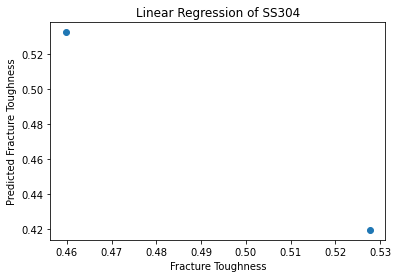

In [370]:
lr_sstype(SS_304,"SS304")

## Ridge Regression

In [371]:
def rr_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model Ridge Rigression
    rr = Ridge(alpha=0.01)
    rr.fit(X_train, y_train) 
    pred_train_rr= rr.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_rr)))
    print("r2 score for training: ", r2_score(y_train, pred_train_rr))
    
    pred_test_rr= rr.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
    print("r2 score for test: ", r2_score(y_test, pred_test_rr))
    
    plt.scatter(y_test,pred_test_rr)
    plt.title("Ridge Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.019138498056893983
r2 score for training:  0.9926811076340909
RMSE test: 0.06600196230828402
r2 score for test:  -2.7643009572742594


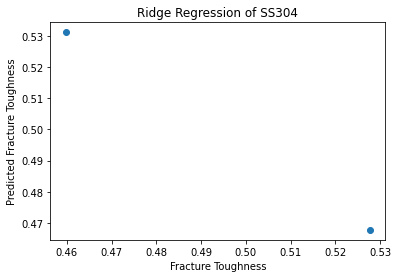

In [372]:
rr_sstype(SS_304,"SS304")

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.06339730724207293
r2 score for training:  0.8824405111653871
RMSE test: 0.10925783983689238
r2 score for test:  -761.9858398084439


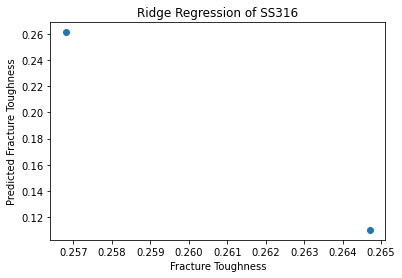

In [373]:
rr_sstype(SS_316,"SS316")

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.00854711585328484
r2 score for training:  0.9990709262057856
RMSE test: 0.15599993118040603
r2 score for test:  -8.650424151884089


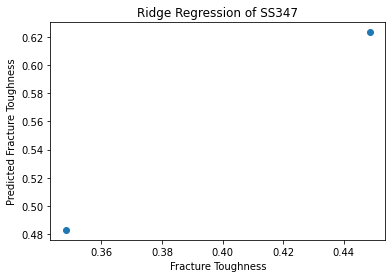

In [374]:
rr_sstype(SS_347,"SS347")

## Elastic net

In [375]:
def enet_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model Ridge Rigression
    model_enet = ElasticNet(alpha = 0.01)
    model_enet.fit(X_train, y_train) 
    pred_train_enet= model_enet.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_enet)))
    print("r2 score for training: ", r2_score(y_train, pred_train_enet))
    
    pred_test_enet= model_enet.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_enet)))
    print("r2 score for test: ", r2_score(y_test, pred_test_enet))
    
    plt.scatter(y_test,pred_test_enet)
    plt.title("Elastic Net Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.048695517842251825
r2 score for training:  0.952618627943394
RMSE test: 0.06450756147029889
r2 score for test:  -2.5957698981911332


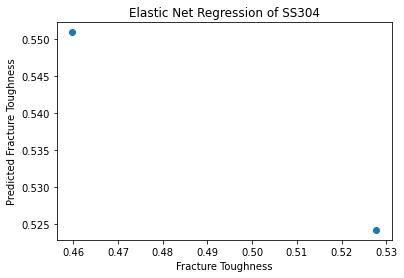

In [376]:
enet_sstype(SS_304,"SS304")

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.12875772626958001
r2 score for training:  0.5150882999601274
RMSE test: 0.03546933350878926
r2 score for test:  -79.41134276126053


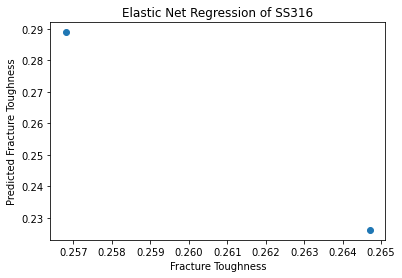

In [377]:
enet_sstype(SS_316,"SS316")

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.043402412652308306
r2 score for training:  0.9760426502885583
RMSE test: 0.1912431179868592
r2 score for test:  -13.50337978817503


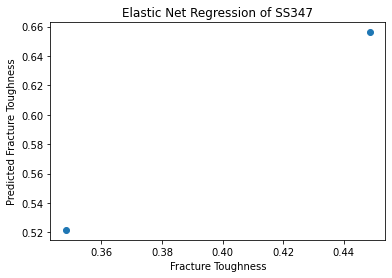

In [378]:
enet_sstype(SS_347,"SS347")

## Lasso 

In [379]:
def lasso_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model LASSO Rigression
    model_lasso = Lasso(alpha=0.01)
    model_lasso.fit(X_train, y_train) 
    pred_train_lasso= model_lasso.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
    print("r2 score for train: ", r2_score(y_train, pred_train_lasso))
    
    pred_test_lasso= model_lasso.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
    print("r2 score for test: ", r2_score(y_test, pred_test_lasso))
    
    plt.scatter(y_test,pred_test_lasso)
    plt.title("LASSO Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.052430745469305304
r2 score for train:  0.9450709964370129
RMSE test: 0.06502897409266538
r2 score for test:  -2.6541338191602604


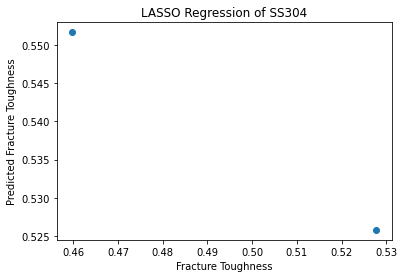

In [380]:
lasso_sstype(SS_304,"SS304")

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.16592641595655813
r2 score for train:  0.194719597543226
RMSE test: 0.04099137199573234
r2 score for test:  -106.39799351622909


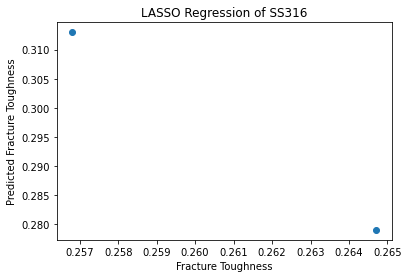

In [381]:
lasso_sstype(SS_316,"SS316")

Training dataset: (3, 4)
Test dataset: (2, 4)
RMSE train: 0.06453610265136525
r2 score for train:  0.9470316434349374
RMSE test: 0.21166591563202541
r2 score for test:  -16.766400475922232


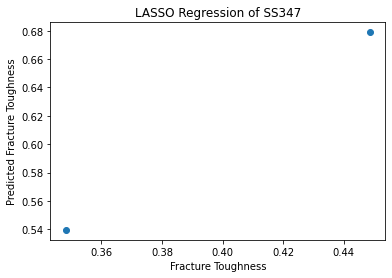

In [382]:
lasso_sstype(SS_347,"SS347")